In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sgkit as sg

import sys
sys.path.append("../../tsimpute/src/")
import vis


In [2]:
# Genetic variation at shared sites
zarr_dir = "../data/zarr/"
ref_ds = sg.load_dataset(zarr_dir + "ref.zarr") # not all allele lists are ACGT
ref_ds_compat = sg.load_dataset(zarr_dir + "ref_compat.zarr")
target_ds_compat = sg.load_dataset(zarr_dir + "target_compat.zarr") # ground-truth
target_chip_ds_compat = sg.load_dataset(zarr_dir + "target_chip_compat.zarr")   # chip-like
lshmm_ds_compat = sg.load_dataset(zarr_dir + "target_lshmm_compat.zarr")    # imputed
beagle_ds_compat = sg.load_dataset(zarr_dir + "target_beagle_compat.zarr")  # imputed


In [3]:
print(f"Sites in ref (full): {ref_ds.dims['variants']}")
print(f"Sites in ref (shared): {ref_ds_compat.dims['variants']}")
print(f"Sites in target (shared): {target_ds_compat.dims['variants']}")
print(f"Sites in target chip (shared): {target_chip_ds_compat.dims['variants']}")
print(f"Sites in lshmm (full): {lshmm_ds_compat.dims['variants']}")
print(f"Sites in BEAGLE (full): {beagle_ds_compat.dims['variants']}")


Sites in ref (full): 504314
Sites in ref (shared): 231630
Sites in target (shared): 231630
Sites in target chip (shared): 7899
Sites in lshmm (full): 504314
Sites in BEAGLE (full): 504314


In [4]:
# Identify non-chip sites
non_chip_site_idx = np.where(np.isin(
    lshmm_ds_compat.variant_position.values,
    target_chip_ds_compat.variant_position.values,
    invert=True,
))[0]
print(len(non_chip_site_idx))


496415


In [12]:
non_chip_site_pos = target_ds_compat.variant_position.values[np.isin(
    target_ds_compat.variant_position.values,
    target_chip_ds_compat.variant_position.values,
    invert=True,
)]
print(len(non_chip_site_pos))


223731


In [14]:
assert lshmm_ds_compat.dims['variants'] == beagle_ds_compat.dims['variants']
non_chip_site_idx = np.where(np.isin(lshmm_ds_compat.variant_position.values, non_chip_site_pos))[0]
lshmm_ds_nonchip_compat = lshmm_ds_compat.isel(variants=non_chip_site_idx)
beagle_ds_nonchip_compat = beagle_ds_compat.isel(variants=non_chip_site_idx)


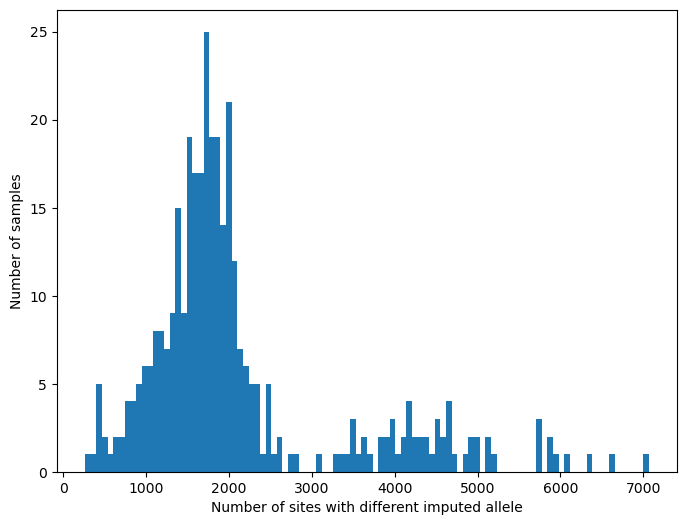

In [16]:
# lshmm vs. BEAGLE (non-chip sites)
diff_lshmm_beagle = np.zeros(
    2 * lshmm_ds_nonchip_compat.dims["samples"],
    dtype=np.int32
)

for i in np.arange(lshmm_ds_compat.dims["samples"]):
    diff_lshmm_beagle[2 * i] = np.sum(np.invert(np.equal(
        lshmm_ds_nonchip_compat.call_genotype[:, i, 0].values,
        beagle_ds_nonchip_compat.call_genotype[:, i, 0].values
    )))
    diff_lshmm_beagle[2 * i + 1] = np.sum(np.invert(np.equal(
        lshmm_ds_nonchip_compat.call_genotype[:, i, 1].values,
        beagle_ds_nonchip_compat.call_genotype[:, i, 1].values
    )))

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(diff_lshmm_beagle, bins=100)
ax.set_ylabel("Number of samples")
ax.set_xlabel("Number of sites with different imputed allele");
